# Deep Learning Models with SMOTE for Korean Vishing Detection

In [162]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-02-22 00:49:55.121876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 00:49:55.121974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 00:49:55.146001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 00:49:56.566845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import library

In [163]:
from time import time
from timeit import default_timer as timer
from datetime import timedelta, datetime
import re
import os
import io
import pickle
import sys
import subprocess
from glob import glob
import csv
import math
import codecs
import copy
from tqdm import tqdm

# EDA
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import numpy as np
import pandas as pd

# NLP & ML 
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    matthews_corrcoef,
    cohen_kappa_score
)

# DL
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    InputSpec,
    Layer, 
    Input,
    Embedding, 
    Conv1D, 
    Conv2D, 
    Bidirectional, 
    Dense, 
    Attention,
    LSTM, 
    Activation, 
    Add, 
    Flatten, 
    Concatenate, 
    concatenate,
    Reshape, 
    Dropout, 
    SpatialDropout1D, 
    BatchNormalization,
    MaxPooling1D, 
    MaxPool2D, 
    GlobalAveragePooling1D, 
    GlobalMaxPooling1D, 
    GlobalMaxPool1D
)
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# SMOTE
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# Plotting code

In [164]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
#     from itertools import izip
    pc.update_scalarmappable()
    ax = pc.axes# FOR LATEST MATPLOTLIB
    
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        # ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      
    
    # save the figure
    plt.savefig('reports/' + title + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + title + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))
    

#
def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)
    
# Function to plot the training and validation loss and accuracy
def plot_loss_accuracy(history, model_name):
    # plot the training and validation loss
    plt.plot(history.epoch, history.history['loss'], '-o', label='Training_loss')
    plt.plot(history.epoch, history.history['val_loss'], '-o', label='Validation_loss')
    plt.title(model_name + ' model loss')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('reports/' + model_name + '_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + model_name + '_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()
    
    # plot the training and validation accuracy
    plt.plot(history.epoch, history.history['accuracy'], '-o', label='Training_accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], '-o', label='Validation_accuracy')
    plt.title(model_name + ' model accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig('reports/' + model_name + '_accuracy' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
    plt.savefig('reports/' + model_name + '_accuracy' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

def plot_class_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    ax = sns.countplot(x='label', data=data)
    ax.set_title(title)
    
    # Annotate the bars with the number of samples
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
    plt.show()

# Function to plot the distribution of the length of the data samples in the train_set, val_set and test_set (boxplot and histogram)
def plot_length_distribution(data, title):
    sns.set(style="whitegrid")
    # sns.set(style="ticks")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    
    # plot the boxplot
    # sns.boxplot(x='length', data=data, ax=ax1)
    sns.boxplot(y='length', x='label', data=data, ax=ax1)
    ax1.set_title('Boxplot')
    
    # plot the histogram
    sns.histplot(x='length', data=data, ax=ax2)
    ax2.set_title('Histogram')
    
    plt.show()

# Data Preprocessing

## Vectorization of the datasets
Encoding the text data into numerical data for the deep learning models

In [165]:
#load the datasets
print('Loading datasets...')
train_set= pd.read_csv('datasets/train_set_ready.csv')
val_set = pd.read_csv('datasets/val_set_ready.csv')
test_set = pd.read_csv('datasets/test_set_ready.csv')

print('Datasets loaded.')

Loading datasets...
Datasets loaded.


In [166]:
train_set.columns = train_set.columns.str.strip()
print("Original length of df:", len(train_set))
train_set.replace([np.inf, -np.inf], np.nan, inplace=True)
train_set.dropna(inplace=True)
print("After droping null values, the length of df:", len(train_set))

Original length of df: 2047
After droping null values, the length of df: 2047


In [167]:
train_set.label.value_counts()

label
0    1562
1     485
Name: count, dtype: int64

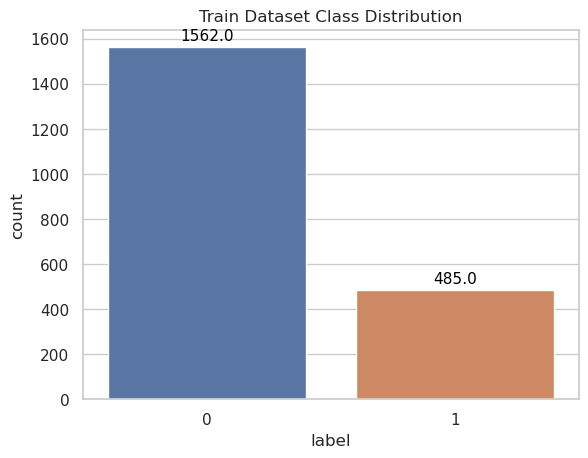

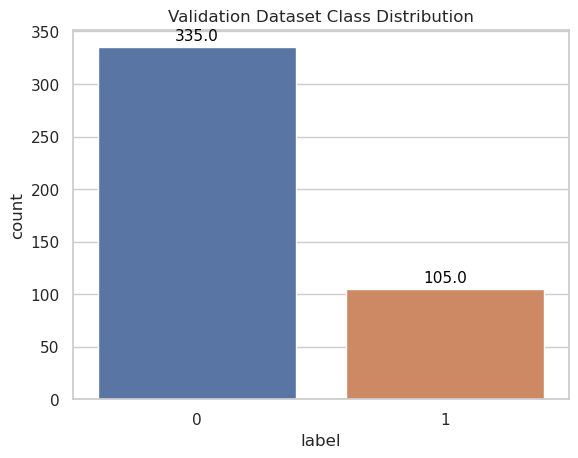

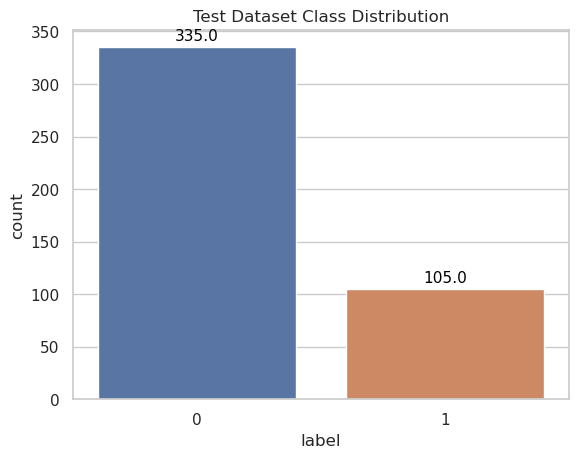

In [168]:
plot_class_distribution(train_set, 'Train Dataset Class Distribution')
plot_class_distribution(val_set, 'Validation Dataset Class Distribution')
plot_class_distribution(test_set, 'Test Dataset Class Distribution')

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


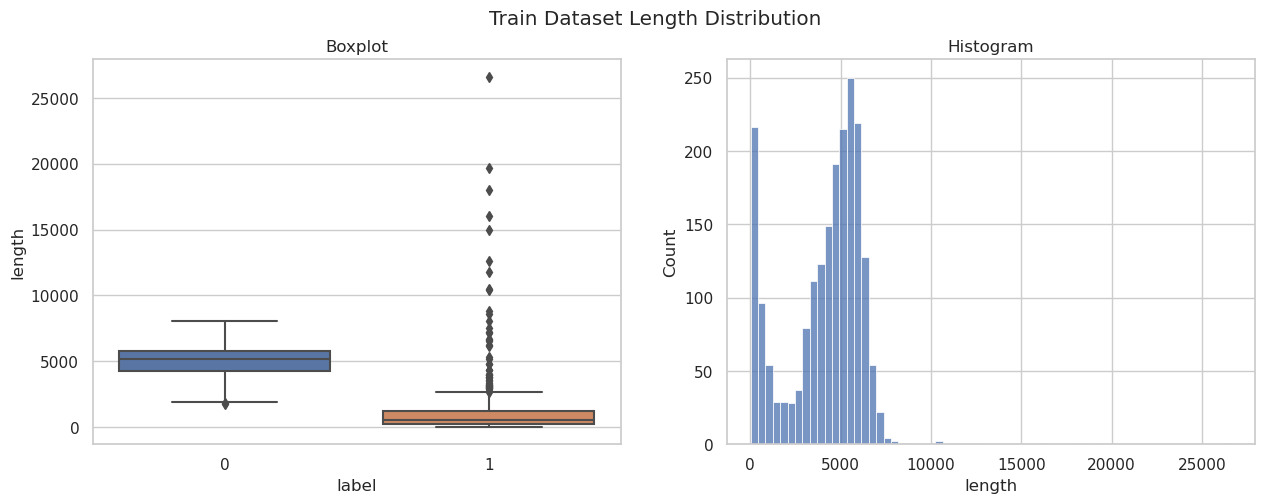

In [169]:
plot_length_distribution(train_set, 'Train Dataset Length Distribution')

In [170]:
# define the train and test sets data from the dataframes
X_train = train_set['corpus']
X_train_1 = train_set['corpus_1']
y_train = train_set['label']

X_val = val_set['corpus']
X_val_1 = val_set['corpus_1']
y_val = val_set['label']

X_test = test_set['corpus']
X_test_1 = test_set['corpus_1']
y_test = test_set['label']

In [171]:
# Function to define the maximum number of words to be used
def max_words_func(X_train, X_val, X_test):
    max_len = 0
    max_words = 0
 
    # check the length of the trainset, the valset and the testset
    print('Train set size = {} \nValidation set size = {} \nTest set size = {}'.format(len(X_train), len(X_val), len(X_test)))
    
    # count the maximum number of words in the trainset
    max_words = len(set(" ".join(X_train).split())) # max number of words for tokenizer
    print('Maximum number of words in the train set = {}'.format(max_words))
    
    # get the maximum length of the sentences in the trainset
    max_len = max([len(x.split()) for x in X_train]) # max length of each sentences, including padding
    print('Maximum length of a sentence in the train set = {}'.format(max_len))

    return max_words, max_len

In [172]:
# define the maximum number of words and the maximum length of the sentences in the trainset
max_words, max_len = max_words_func(X_train, X_val, X_test)

Train set size = 2047 
Validation set size = 440 
Test set size = 440
Maximum number of words in the train set = 33844
Maximum length of a sentence in the train set = 4715


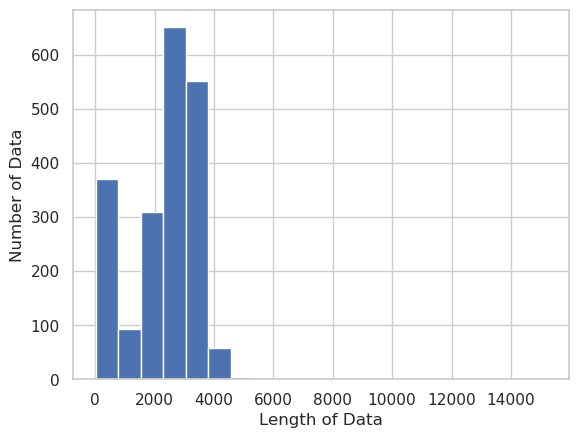

In [173]:
plt.hist([len(s) for s in X_train], bins=20)
plt.xlabel('Length of Data')
plt.ylabel('Number of Data')
plt.show()

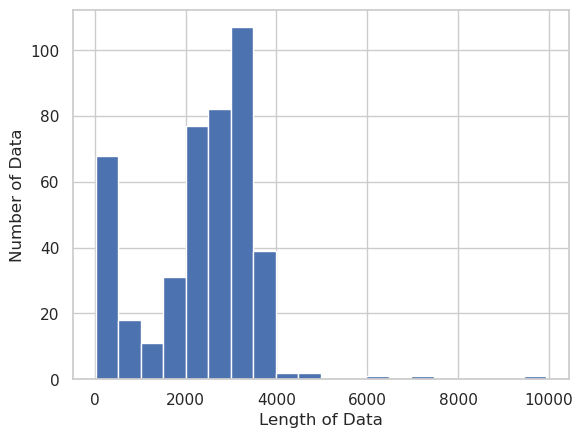

In [174]:
plt.hist([len(s) for s in X_test], bins=20)
plt.xlabel('Length of Data')
plt.ylabel('Number of Data')
plt.show()

### Training with the original train_set dataset

In [175]:
# Function to tokenize the text data
def tokenize_text(X_train, X_val, X_test, max_words=max_words, max_len=max_len):
    # define the tokenizer and tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=False, char_level=False)
    tokenizer.fit_on_texts(X_train)  #leaky
    
    # Function to convert texts to sequences of integers
    def texts_to_sequences(X_train, X_val, X_test):
        # convert texts to sequences of integers
        X_train_seq = tokenizer.texts_to_sequences(X_train)
        X_val_seq = tokenizer.texts_to_sequences(X_val)
        X_test_seq = tokenizer.texts_to_sequences(X_test)
        word_index = tokenizer.word_index
        
        print("Dictionary size: ", len(word_index))
        
        return X_train_seq, X_val_seq, X_test_seq, word_index
    
    # define the sequences of integers
    X_train_seq, X_val_seq, X_test_seq, word_index = texts_to_sequences(X_train, X_val, X_test)
    
    # FPad the sequences to ensure uniform length
    X_train_pad = pad_sequences(X_train_seq, padding='pre', maxlen=max_len)
    X_val_pad = pad_sequences(X_val_seq, padding='pre', maxlen=max_len)
    X_test_pad = pad_sequences(X_test_seq, padding='pre', maxlen=max_len)
    
    return X_train_pad, X_val_pad, X_test_pad, word_index

In [176]:
# tokenize the text data
X_train_pad, X_val_pad, X_test_pad, word_index = tokenize_text(X_train, X_val, X_test, max_words, max_len)

Dictionary size:  33844


### Applying SMOTE methods to balance the training set dataset

In [177]:
# Function to balance the training dataset according to the selected SMOTE methods
def balance_trainset(X_train, y_train, method='SMOTE'):
    #name for oversampling method
    over_name = ''
    
    # define the SMOTE method
    if method == 'SMOTE':
        smote = SMOTE(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'ADASYN':
        smote = ADASYN(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'SMOTEENN':
        smote = SMOTEENN(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'SMOTETomek':
        smote = SMOTETomek(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'SVMSMOTE':
        smote = SVMSMOTE(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'KMeansSMOTE':
        smote = KMeansSMOTE(random_state=42)
        over_name = smote.__class__.__name__
    elif method == 'BorderlineSMOTE':
        smote = BorderlineSMOTE(random_state=42)
        over_name = smote.__class__.__name__
    else:
        smote = SMOTE(random_state=42)
        over_name = smote.__class__.__name__
    
    # Dataset shape
    print("-- Dataset shape --")
    print('Original dataset shape')
    print(Counter(y_train),'\n')#Counting the samples in training set
        
    # resampling/fit the SMOTE model to the trainset
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print(over_name)
    print('Resampled training set shape %s' % Counter(y_train_res))
    
    return X_train_res, y_train_res, over_name

In [178]:
# select the SMOTE method to balance the training dataset
smote_method = 'BorderlineSMOTE'
X_train_res, y_train_res, over_name = balance_trainset(X_train_pad, y_train, smote_method)

-- Dataset shape --
Original dataset shape
Counter({0: 1562, 1: 485}) 

BorderlineSMOTE
Resampled training set shape Counter({0: 1562, 1: 485})


# Model Building and Training

## Importing the FastText word embeddings

In [179]:
# run if the wiki.ko.vec is not available in the same directory
import os
import urllib.request
# check if the file wiki.ko.vec is in the directory if not download it
if not os.path.isfile('wiki.ko.vec'):
    print('wiki.ko.vec does not exist, downloading file from the internet')
    # download the FastText word embeddings and monitor the download progress bar with tqdm
    with tqdm(unit='B', unit_scale=True, miniters=1, desc='wiki.ko.vec') as t:
        urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec', reporthook=lambda a,b,c: t.update(c))
    # urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ko.vec', 'wiki.ko.vec')
else:
    print('wiki.ko.vec exists, will not download file from the internet')

wiki.ko.vec exists, will not download file from the internet


In [19]:
# import the FastText word embeddings
print('Loading word FastText embeddings...')
embeddings_index = {}
f = codecs.open('wiki.ko.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Loading word FastText embeddings...


879131it [17:05, 857.36it/s] 


In [100]:
print('Found %s word vectors' % len(embeddings_index))

Found 879130 word vectors


In [180]:
# define the preprocessing parameters
embedding_dim = 300 # embedding dimensions for word vectors (word2vec/GloVe/Fasttext)

# defining the hyperparameters
learning_rate = 1e-3
batch_size= 32 # 64, 128
epochs = 10
steps_per_epoch = len(X_train) // batch_size  # total_samples is the training set size

# Calculating decay steps
# It's common to decay the learning rate at each epoch
decay_steps = steps_per_epoch * epochs # 10000
decay_rate = 0.9  # This is a common decay rate, but you can adjust it
# learning_decay = 1e-10 # 1e-4

spa_dropout_ratio = 0.2 # dropout ration, dropping a entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.2 # 0.1, 0.2 to 0.5 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.

### Preparing FastText embedding matrix for future use

In [181]:
#embedding matrix
# print('Preparing embedding matrix for future use...')
words_not_found = []
embed_dim = embedding_dim #300 # 32 Dimensions of the embedding vector
nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((max_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

number of null word embeddings: 8636
sample words not found:  ['실관' '달려드' '드려볼까' '반항심' '닥쳐야' '연줄' '뜯겼' '빡세' '다대요' '야서']


In [182]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])
df_results

,F1_score,Precision,Recall,Accuracy,Training time


## Training with default embedding layer and the SMOTE sampling method

### Single LSTM layer

In [183]:
# write a function to build, train and evaluate the LSTM model
def build_train_lstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(LSTM(lstm_units_1))
    model.add(Dense(dense_units, activation='relu'))
    # model.add(LSTM(lstm_units_1, dropout=dropout_ratio, recurrent_dropout=dropout_ratio))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/LSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    # np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [184]:
# build, train and evaluate the LSTM model
model_name = over_name + '_LSTM'
model_lstm, history_lstm, report_lstm = build_train_lstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 lstm_24 (LSTM)              (None, 64)                93440     
                                                                 
 dense_48 (Dense)            (None, 64)                4160      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10250865 (39.10 MB)
Trainable params: 97665 (381.50 KB)
Non-trainable params: 10153200 (38.73 MB)
_________________________________________________________________
None
##

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 20s 283ms/step - loss: 0.3781 - accuracy: 0.8319 - val_loss: 0.0971 - val_accuracy: 0.9955
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9888
Epoch 2: val_accuracy did not improve from 0.99545
64/64 [==============================] - 17s 261ms/step - loss: 0.0563 - accuracy: 0.9888 - val_loss: 0.0337 - val_accuracy: 0.9932
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9956
Epoch 3: val_accuracy did not improve from 0.99545
64/64 [==============================] - 16s 249ms/step - loss: 0.0281 - accuracy: 0.9956 - val_loss: 0.0762 - val_accuracy: 0.9841
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.9507
Epoch 4: val_accuracy did not improve from 0.99545
64/64 [==============================] - 17s 262ms/step - loss: 0.1201 - accuracy: 0.9507 - val_loss: 0.1055 - val_accuracy: 0.9795
Epoch 5/10
64/64 [===================

In [185]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.0,0.997727,85.745191


#### Plot the results

[1.0, 0.997, 0.9985]
[0.9906, 1.0, 0.9953]
plotMat: [[1.0, 0.997, 0.9985], [0.9906, 1.0, 0.9953]]
support: [335, 105]


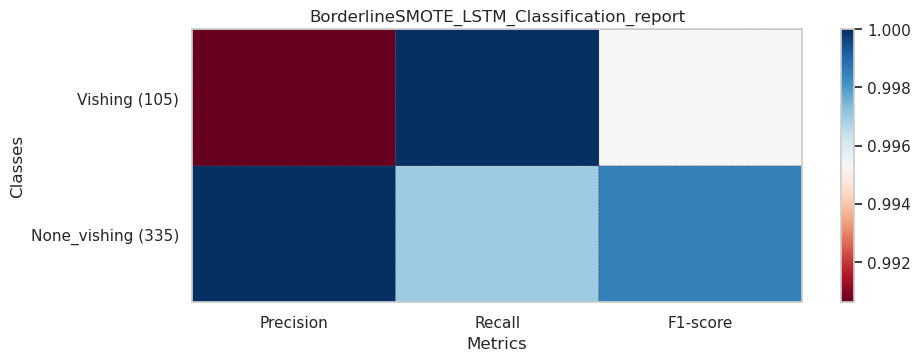

In [186]:
plot_name = over_name + '_LSTM_Classification_report'
plot_classification_report(report_lstm, plot_name)

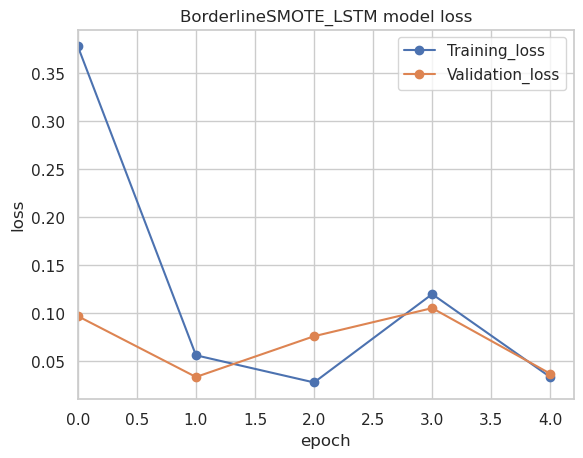

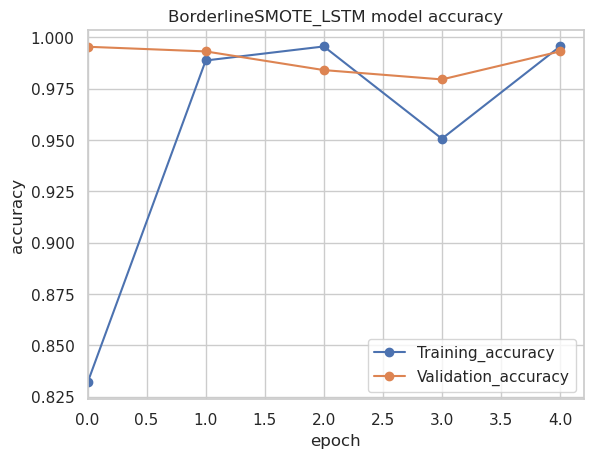

In [187]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_LSTM'
plot_loss_accuracy(history_lstm, plot_name)

In [188]:
# plot the tensorboard results
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# %tensorboard --logdir logs/fit

### Single LSTM layer with FastText embedding layer

In [189]:
# build, train and evaluate the LSTM model
model_name = over_name + '_LSTM_FT'
model_lstm_ft, history_lstm_ft, report_lstm_ft = build_train_lstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 lstm_25 (LSTM)              (None, 64)                93440     
                                                                 
 dense_50 (Dense)            (None, 64)                4160      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10250865 (39.10 MB)
Trainable params: 97665 (381.50 KB)
Non-trainable params: 10153200 (38.73 MB)
_________________________________________________________________
None
##

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 22s 313ms/step - loss: 0.1879 - accuracy: 0.9170 - val_loss: 0.0311 - val_accuracy: 0.9909
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9966
Epoch 2: val_accuracy improved from 0.99091 to 1.00000, saving model to models/BorderlineSMOTE_LSTM_FT_20240222_005207.h5
64/64 [==============================] - 16s 245ms/step - loss: 0.0138 - accuracy: 0.9966 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9995
Epoch 3: val_accuracy did not improve from 1.00000
64/64 [==============================] - 16s 252ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0118 - val_accuracy: 0.9932
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.6095 - accuracy: 0.8090
Epoch 4: val_accuracy did not improve from 1.00000
64/64 [==============================] - 16s 249ms/step - loss: 0.6095 - accuracy: 0.8090 - val_lo

In [190]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069


[0.7631, 1.0, 0.8656]
[1.0, 0.0095, 0.0189]
plotMat: [[0.7631, 1.0, 0.8656], [1.0, 0.0095, 0.0189]]
support: [335, 105]


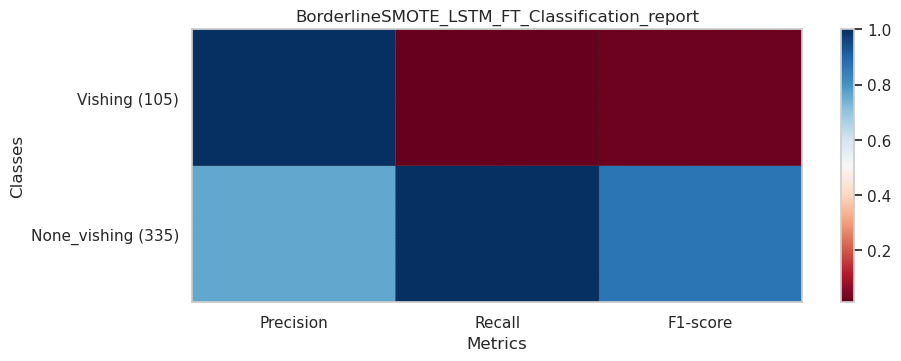

In [191]:
plot_name = over_name + '_LSTM_FT_Classification_report'
plot_classification_report(report_lstm_ft, plot_name)

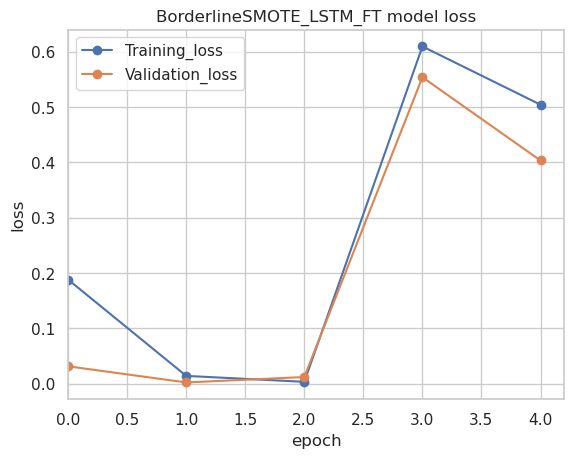

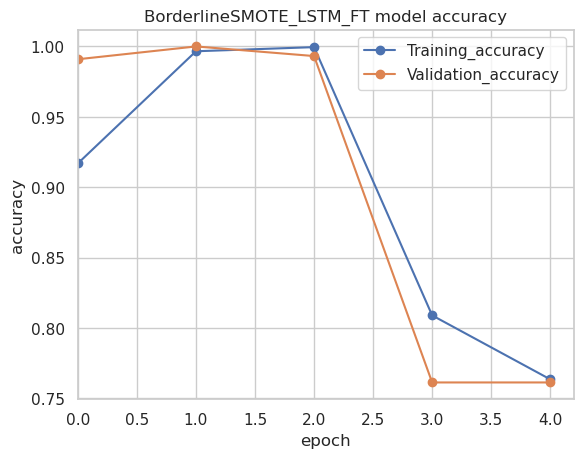

In [192]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_LSTM_FT'
plot_loss_accuracy(history_lstm_ft, plot_name)

### Stacked LSTM layers


In [193]:
# write a function to build, train and evaluate the LSTM model
def build_train_stackedlstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(LSTM(lstm_units_1, return_sequences=True))
    model.add(LSTM(lstm_units_2))
    model.add(Dense(dense_units, activation='relu'))
    # model.add(LSTM(lstm_units_1, dropout=dropout_ratio, recurrent_dropout=dropout_ratio))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    # np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')

    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [194]:
# build, train and evaluate the stacked LSTM layers model
model_name = over_name + '_stackedLSTM'
model_stackedlstm, history_stackedlstm, report_stackedlstm = build_train_stackedlstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 lstm_26 (LSTM)              (None, 4715, 64)          93440     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dense_52 (Dense)            (None, 64)                2112      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_53 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10261233 (39.14 MB)
Trainable params: 1

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 43s 508ms/step - loss: 0.3630 - accuracy: 0.8598 - val_loss: 0.0247 - val_accuracy: 0.9955
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9751
Epoch 2: val_accuracy did not improve from 0.99545
64/64 [==============================] - 32s 501ms/step - loss: 0.1326 - accuracy: 0.9751 - val_loss: 0.1057 - val_accuracy: 0.9795
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9873
Epoch 3: val_accuracy improved from 0.99545 to 0.99773, saving model to models/BorderlineSMOTE_stackedLSTM_20240222_005339.h5
64/64 [==============================] - 32s 501ms/step - loss: 0.0703 - accuracy: 0.9873 - val_loss: 0.0258 - val_accuracy: 0.9977
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9917
Epoch 4: val_accuracy did not improve from 0.99773
64/64 [==============================] - 32s 493ms/step - loss: 0.0539 - accuracy: 0.9917 - va

In [195]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577


[0.9517, 1.0, 0.9753]
[1.0, 0.8381, 0.9119]
plotMat: [[0.9517, 1.0, 0.9753], [1.0, 0.8381, 0.9119]]
support: [335, 105]


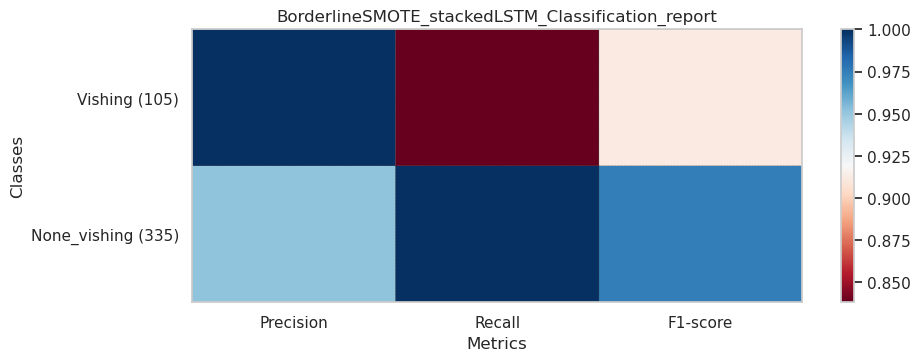

In [196]:
plot_name = over_name + '_stackedLSTM_Classification_report'
plot_classification_report(report_stackedlstm, plot_name)

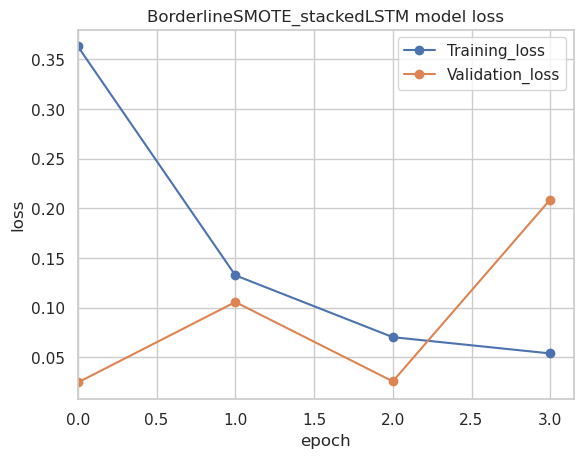

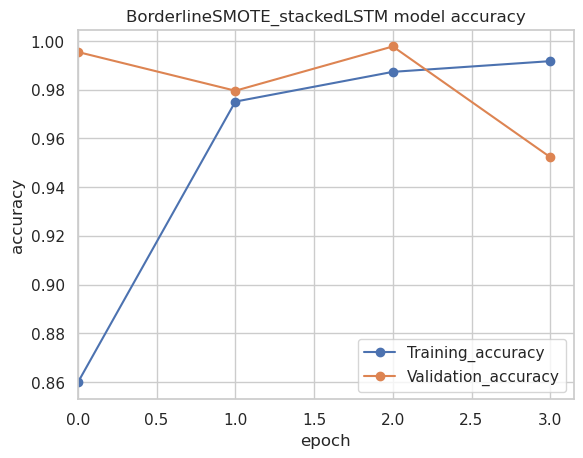

In [197]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_stackedLSTM'
plot_loss_accuracy(history_stackedlstm, plot_name)

### Stacked LSTM layer with FastText embedding layer


In [198]:
# build, train and evaluate the stacked LSTM layers model with FastText embedding layer
model_name = over_name + '_stackedLSTM_FT'
model_stackedlstm_ft, history_stackedlstm_ft, report_stackedlstm_ft = build_train_stackedlstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 lstm_28 (LSTM)              (None, 4715, 64)          93440     
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dense_54 (Dense)            (None, 64)                2112      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10261233 (39.14 MB)
Trainable params: 1

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 37s 525ms/step - loss: 0.2295 - accuracy: 0.9145 - val_loss: 0.0555 - val_accuracy: 0.9864
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9135
Epoch 2: val_accuracy improved from 0.98636 to 0.99545, saving model to models/BorderlineSMOTE_stackedLSTM_FT_20240222_005610.h5
64/64 [==============================] - 31s 493ms/step - loss: 0.2288 - accuracy: 0.9135 - val_loss: 0.1022 - val_accuracy: 0.9955
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9111
Epoch 3: val_accuracy did not improve from 0.99545
64/64 [==============================] - 32s 502ms/step - loss: 0.2700 - accuracy: 0.9111 - val_loss: 1.3630 - val_accuracy: 0.2409
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.5596 - accuracy: 0.6781
Epoch 4: val_accuracy did not improve from 0.99545
64/64 [==============================] - 31s 486ms/step - loss: 0.5596 - accuracy: 0.6781 -

In [199]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794


[1.0, 0.9731, 0.9864]
[0.9211, 1.0, 0.9589]
plotMat: [[1.0, 0.9731, 0.9864], [0.9211, 1.0, 0.9589]]
support: [335, 105]


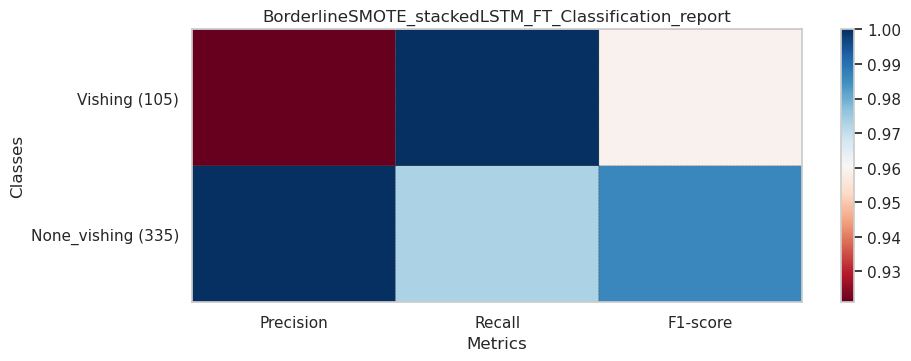

In [200]:
#plot the confusion matrix
plot_name = over_name + '_stackedLSTM_FT_Classification_report'
plot_classification_report(report_stackedlstm_ft, plot_name)

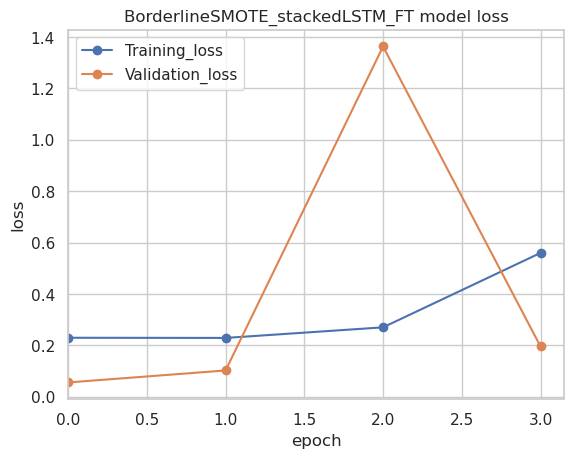

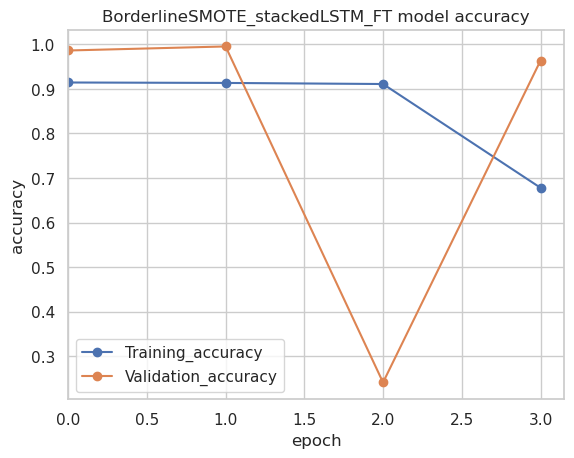

In [201]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_stackedLSTM_FT'
plot_loss_accuracy(history_stackedlstm_ft, plot_name)

### Single BiLSTM layer

In [202]:
# Function to build, train and evaluate the BiLSTM model
def build_train_bilstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Bidirectional(LSTM(lstm_units_1)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    # np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [203]:
# build, train and evaluate the BiLSTM model
model_name = over_name + '_BiLSTM'
model_bilstm, history_bilstm, report_bilstm = build_train_bilstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 bidirectional_12 (Bidirect  (None, 128)               186880    
 ional)                                                          
                                                                 
 dense_56 (Dense)            (None, 64)                8256      
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 dense_57 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10348401 (39.48 MB)
Trainable params: 195201 (762.50 KB)
Non-trainable params: 10153200 (38.73 MB)
______

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 36s 516ms/step - loss: 0.3330 - accuracy: 0.8735 - val_loss: 0.0508 - val_accuracy: 0.9955
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9897
Epoch 2: val_accuracy did not improve from 0.99545
64/64 [==============================] - 36s 564ms/step - loss: 0.0704 - accuracy: 0.9897 - val_loss: 0.3738 - val_accuracy: 0.9341
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.9043
Epoch 3: val_accuracy did not improve from 0.99545
64/64 [==============================] - 31s 490ms/step - loss: 0.3160 - accuracy: 0.9043 - val_loss: 0.2349 - val_accuracy: 0.9318
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9863
Epoch 4: val_accuracy did not improve from 0.99545
64/64 [==============================] - 32s 505ms/step - loss: 0.0699 - accuracy: 0.9863 - val_loss: 0.0910 - val_accuracy: 0.9864
Epoch 4: early stopping
Training time

In [204]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794
BorderlineSMOTE_BiLSTM,0.980583,1.000000,0.961905,0.990909,135.702678


[0.9882, 1.0, 0.9941]
[1.0, 0.9619, 0.9806]
plotMat: [[0.9882, 1.0, 0.9941], [1.0, 0.9619, 0.9806]]
support: [335, 105]


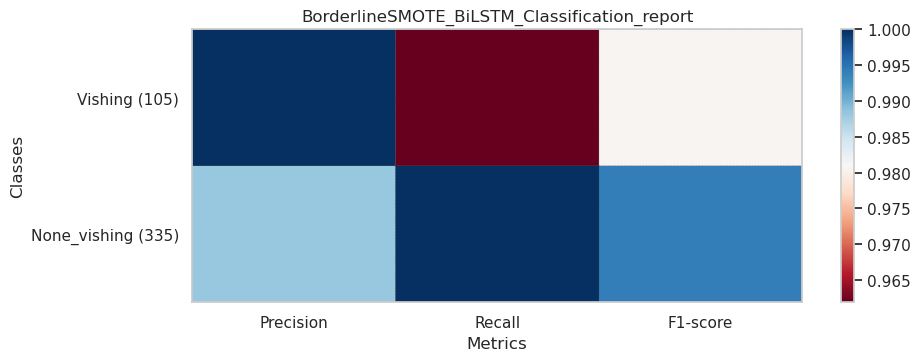

In [205]:
#plot the confusion matrix
plot_name = over_name + '_BiLSTM_Classification_report'
plot_classification_report(report_bilstm, plot_name)

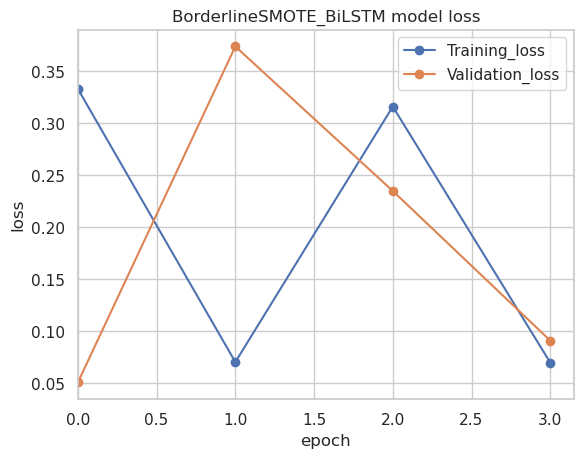

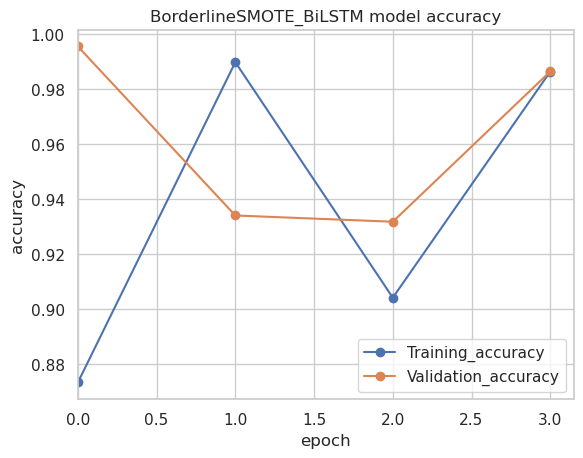

In [206]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_BiLSTM'
plot_loss_accuracy(history_bilstm, plot_name)

### Single BiLSTM layer with FastText embedding layer

In [207]:
# build, train and evaluate the BiLSTM model with FastText embedding layer
model_name = over_name + '_BiLSTM_FT'
model_bilstm_ft, history_bilstm_ft, report_bilstm_ft = build_train_bilstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 bidirectional_13 (Bidirect  (None, 128)               186880    
 ional)                                                          
                                                                 
 dense_58 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10348401 (39.48 MB)
Trainable params: 195201 (762.50 KB)
Non-trainable params: 10153200 (38.73 MB)
______

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 34s 485ms/step - loss: 0.2394 - accuracy: 0.8959 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9897
Epoch 2: val_accuracy did not improve from 1.00000
64/64 [==============================] - 32s 497ms/step - loss: 0.0440 - accuracy: 0.9897 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980
Epoch 3: val_accuracy did not improve from 1.00000
64/64 [==============================] - 31s 484ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
64/64 [==============================] - 30s 466ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 8.0980e-04 - val_accuracy: 1.0000
Epoch 5/10
64/64 [===============

In [208]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794
BorderlineSMOTE_BiLSTM,0.980583,1.000000,0.961905,0.990909,135.702678
BorderlineSMOTE_BiLSTM_FT,1.000000,1.000000,1.000000,1.000000,222.469178


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


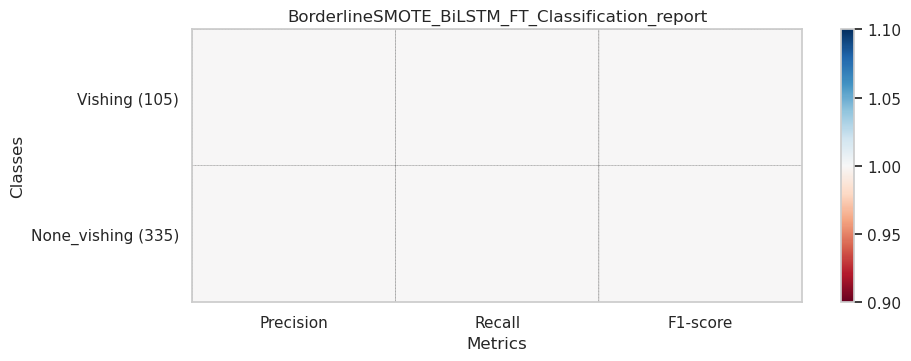

In [209]:
#plot the confusion matrix
plot_name = over_name + '_BiLSTM_FT_Classification_report'
plot_classification_report(report_bilstm_ft, plot_name)

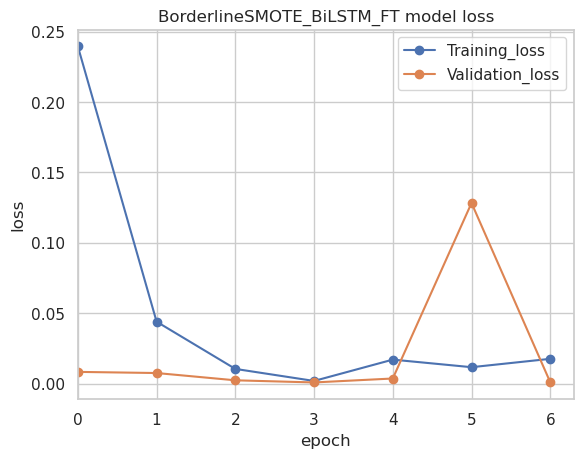

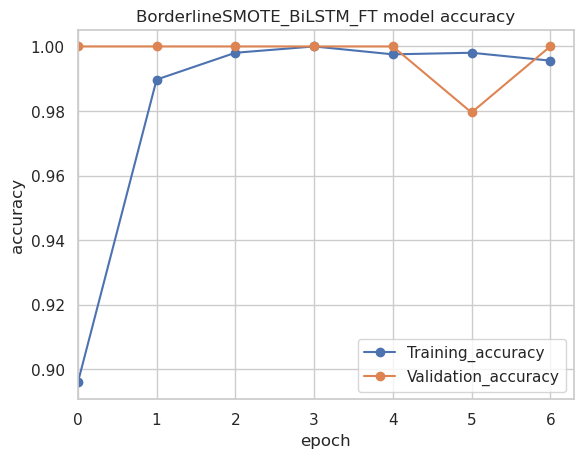

In [210]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_BiLSTM_FT'
plot_loss_accuracy(history_bilstm_ft, plot_name)

### Stacked BiLSTM layers

In [211]:
# Function to build, train and evaluate the stacked BiLSTM model
def build_train_stackedbilstm_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))
    
    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Bidirectional(LSTM(lstm_units_1,return_sequences=True)))
    model.add(Bidirectional(LSTM(lstm_units_2)))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_loss
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    # np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [212]:
# build, train and evaluate the stacked BiLSTM model
model_name = over_name + '_stackedBiLSTM'
model_stackedbilstm, history_stackedbilstm, report_stackedbilstm = build_train_stackedbilstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 bidirectional_14 (Bidirect  (None, 4715, 128)         186880    
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_60 (Dense)            (None, 64)                4160      
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 1)               

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 79s 1s/step - loss: 0.2816 - accuracy: 0.8896 - val_loss: 0.0476 - val_accuracy: 0.9932
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 0.9966
Epoch 2: val_accuracy improved from 0.99318 to 0.99545, saving model to models/BorderlineSMOTE_stackedBiLSTM_20240222_010448.h5
64/64 [==============================] - 66s 1s/step - loss: 0.0247 - accuracy: 0.9966 - val_loss: 0.0222 - val_accuracy: 0.9955
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9995
Epoch 3: val_accuracy improved from 0.99545 to 0.99773, saving model to models/BorderlineSMOTE_stackedBiLSTM_20240222_010448.h5
64/64 [==============================] - 68s 1s/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0135 - val_accuracy: 0.9977
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9912
Epoch 4: val_accuracy did not improve from 0.99773
64/64 [=================

In [213]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794
BorderlineSMOTE_BiLSTM,0.980583,1.000000,0.961905,0.990909,135.702678
BorderlineSMOTE_BiLSTM_FT,1.000000,1.000000,1.000000,1.000000,222.469178
BorderlineSMOTE_stackedBiLSTM,1.000000,1.000000,1.000000,1.000000,401.532476


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


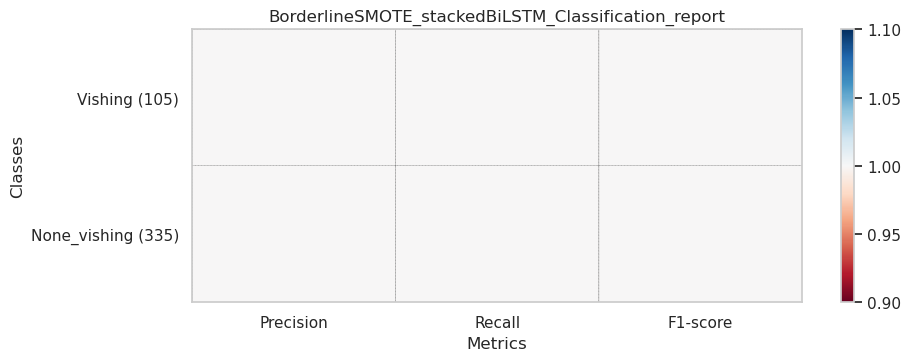

In [214]:
#plot the confusion matrix
plot_name = over_name + '_stackedBiLSTM_Classification_report'
plot_classification_report(report_stackedbilstm, plot_name)

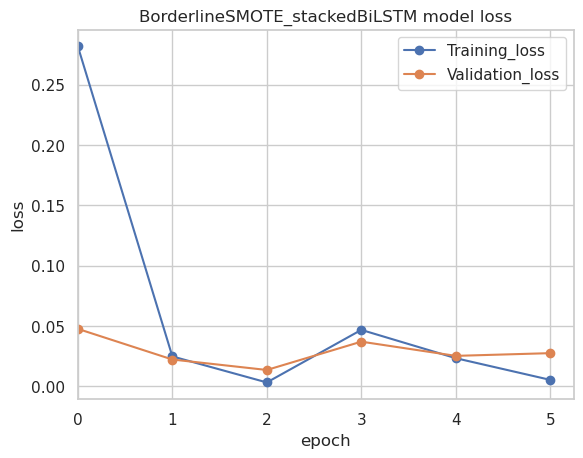

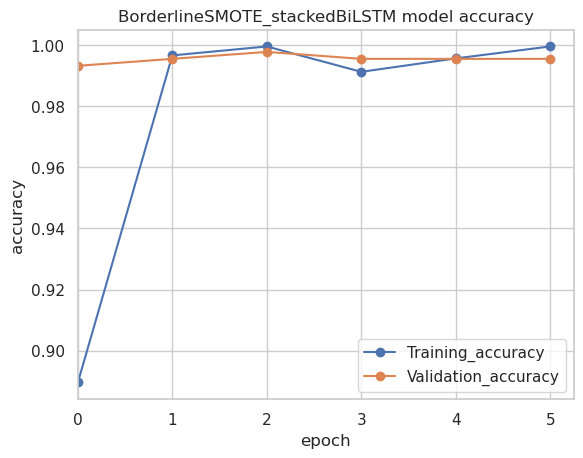

In [215]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_stackedBiLSTM'
plot_loss_accuracy(history_stackedbilstm, plot_name)

### Stacked BiLSTM layer with FastText embedding layer with FastText embedding layer

In [216]:
# build, train and evaluate the stacked BiLSTM model with FastText embedding layer
model_name = over_name + '_stackedBiLSTM_FT'
model_stackedbilstm_ft, history_stackedbilstm_ft, report_stackedbilstm_ft = build_train_stackedbilstm_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 bidirectional_16 (Bidirect  (None, 4715, 128)         186880    
 ional)                                                          
                                                                 
 bidirectional_17 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_62 (Dense)            (None, 64)                4160      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_63 (Dense)            (None, 1)               

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 71s 1s/step - loss: 0.2623 - accuracy: 0.9043 - val_loss: 0.0466 - val_accuracy: 0.9886
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9428
Epoch 2: val_accuracy improved from 0.98864 to 0.99091, saving model to models/BorderlineSMOTE_stackedBiLSTM_FT_20240222_011145.h5
64/64 [==============================] - 61s 962ms/step - loss: 0.1426 - accuracy: 0.9428 - val_loss: 0.0285 - val_accuracy: 0.9909
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9932
Epoch 3: val_accuracy improved from 0.99091 to 0.99773, saving model to models/BorderlineSMOTE_stackedBiLSTM_FT_20240222_011145.h5
64/64 [==============================] - 61s 948ms/step - loss: 0.0276 - accuracy: 0.9932 - val_loss: 0.0093 - val_accuracy: 0.9977
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9936
Epoch 4: val_accuracy did not improve from 0.99773
64/64 [=====

In [217]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794
BorderlineSMOTE_BiLSTM,0.980583,1.000000,0.961905,0.990909,135.702678
BorderlineSMOTE_BiLSTM_FT,1.000000,1.000000,1.000000,1.000000,222.469178
BorderlineSMOTE_stackedBiLSTM,1.000000,1.000000,1.000000,1.000000,401.532476
BorderlineSMOTE_stackedBiLSTM_FT,1.000000,1.000000,1.000000,1.000000,638.131935


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


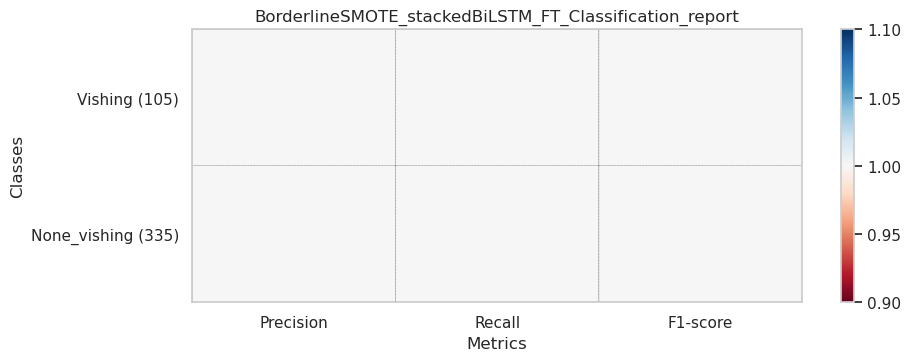

In [218]:
#plot the confusion matrix
plot_name = over_name + '_stackedBiLSTM_FT_Classification_report'
plot_classification_report(report_stackedbilstm_ft, plot_name)

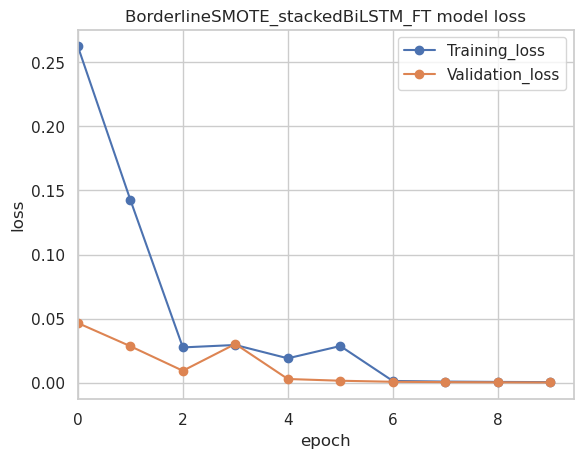

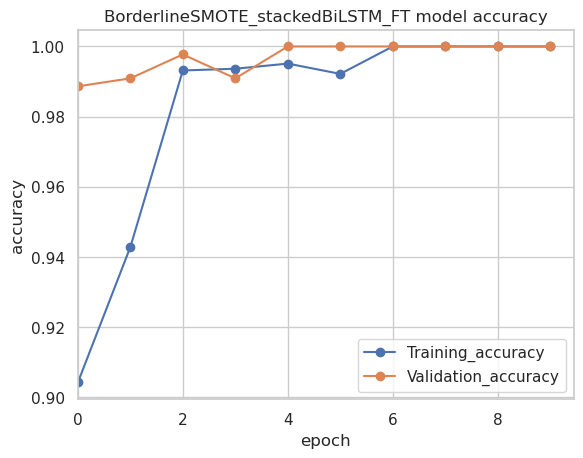

In [219]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_stackedBiLSTM_FT'
plot_loss_accuracy(history_stackedbilstm_ft, plot_name)

### 1D CNN Layer

In [220]:
# Function to build, train and evaluate the stacked BiLSTM model
def build_train_cnn_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))

    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='valid'))
    model.add(MaxPooling1D())
    # model.add(GlobalMaxPooling1D()) #takes the maximum value over the time dimension from each feature map generated by the convolutional layers, Dimensionality Reduction, Reduces Overfitting
    model.add(Dense(dense_units, activation='relu'))
    model.add(Flatten()) # no need if used Global poooling
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
    
    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate
    )
    
    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer = Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    # print the model summary
    print(model.summary())
    print('#' * 150)
    
    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy', # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max' # max for val_accuracy, min for val_lossmode='mn'
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor = 'val_loss',
        verbose = 1,
        patience = 3, # Number of epochs with no improvement after which training will be stopped.
        mode = 'min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time
    
    # print the training time
    print('Training time: {}'.format(training_time))
    
    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))
    
    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)
    
    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))
        
    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)
    
    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    # np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))
    
    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  
    
    # print the results
    # df_results
    
    return model, history, report

In [221]:
# build, train and evaluate the CNN model
model_name = over_name + '_CNN'
model_cnn, history_cnn, report_cnn = build_train_cnn_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 conv1d_16 (Conv1D)          (None, 4713, 50)          45050     
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 2356, 50)          0         
 ng1D)                                                           
                                                                 
 dense_64 (Dense)            (None, 2356, 64)          3264      
                                                                 
 flatten_8 (Flatten)         (None, 150784)            0         
                                                                 
 dropout_32 (Dropout)        (None, 150784)            0         
                                                     

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 4s 51ms/step - loss: 0.1402 - accuracy: 0.9468 - val_loss: 0.0777 - val_accuracy: 0.9659
Epoch 2/10
63/64 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9950
Epoch 2: val_accuracy improved from 0.96591 to 1.00000, saving model to models/BorderlineSMOTE_CNN_20240222_012239.h5
64/64 [==============================] - 2s 32ms/step - loss: 0.0152 - accuracy: 0.9951 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 3/10
61/64 [===========================>..] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
64/64 [==============================] - 1s 23ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
64/64 [==============================] - 1s 23ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0041 -

In [222]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794
BorderlineSMOTE_BiLSTM,0.980583,1.000000,0.961905,0.990909,135.702678
BorderlineSMOTE_BiLSTM_FT,1.000000,1.000000,1.000000,1.000000,222.469178
BorderlineSMOTE_stackedBiLSTM,1.000000,1.000000,1.000000,1.000000,401.532476
BorderlineSMOTE_stackedBiLSTM_FT,1.000000,1.000000,1.000000,1.000000,638.131935
BorderlineSMOTE_CNN,1.000000,1.000000,1.000000,1.000000,17.637071


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


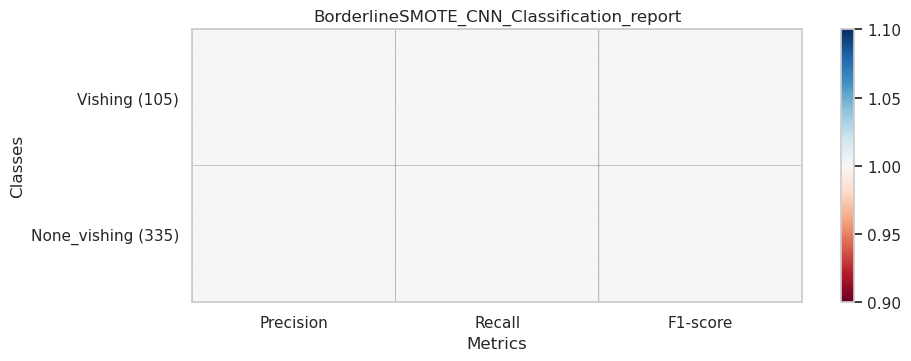

In [223]:
#plot the confusion matrix
plot_name = over_name + '_CNN_Classification_report'
plot_classification_report(report_cnn, plot_name)

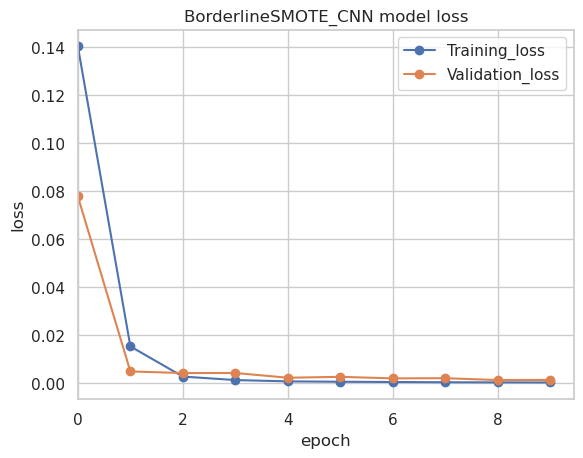

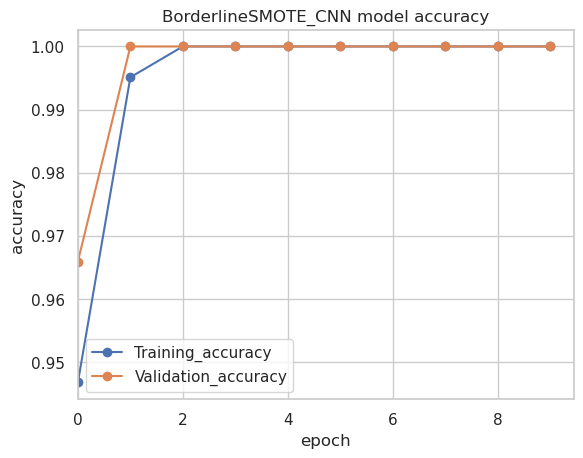

In [224]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_CNN'
plot_loss_accuracy(history_cnn, plot_name)

#### 1D CNN layer with FastText embedding layer

In [225]:
# build, train and evaluate the CNN model with FastText embedding layer
model_name = over_name + '_CNN_FT'
model_cnn_ft, history_cnn_ft, report_cnn_ft = build_train_cnn_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 conv1d_17 (Conv1D)          (None, 4713, 50)          45050     
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 2356, 50)          0         
 ng1D)                                                           
                                                                 
 dense_66 (Dense)            (None, 2356, 64)          3264      
                                                                 
 flatten_9 (Flatten)         (None, 150784)            0         
                                                                 
 dropout_33 (Dropout)        (None, 150784)            0         
                                                     

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 3s 39ms/step - loss: 0.1131 - accuracy: 0.9634 - val_loss: 0.0200 - val_accuracy: 0.9932
Epoch 2/10
62/64 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9980
Epoch 2: val_accuracy improved from 0.99318 to 1.00000, saving model to models/BorderlineSMOTE_CNN_FT_20240222_012259.h5
64/64 [==============================] - 2s 28ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/10
61/64 [===========================>..] - ETA: 0s - loss: 5.8963e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
64/64 [==============================] - 1s 22ms/step - loss: 5.9514e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 2.6936e-04 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
64/64 [==============================] - 1s 23ms/step - loss: 2.6936e-04 - accuracy: 1.0000 -

In [226]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794
BorderlineSMOTE_BiLSTM,0.980583,1.000000,0.961905,0.990909,135.702678
BorderlineSMOTE_BiLSTM_FT,1.000000,1.000000,1.000000,1.000000,222.469178
BorderlineSMOTE_stackedBiLSTM,1.000000,1.000000,1.000000,1.000000,401.532476
BorderlineSMOTE_stackedBiLSTM_FT,1.000000,1.000000,1.000000,1.000000,638.131935
BorderlineSMOTE_CNN,1.000000,1.000000,1.000000,1.000000,17.637071
BorderlineSMOTE_CNN_FT,1.000000,1.000000,1.000000,1.000000,16.766783


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


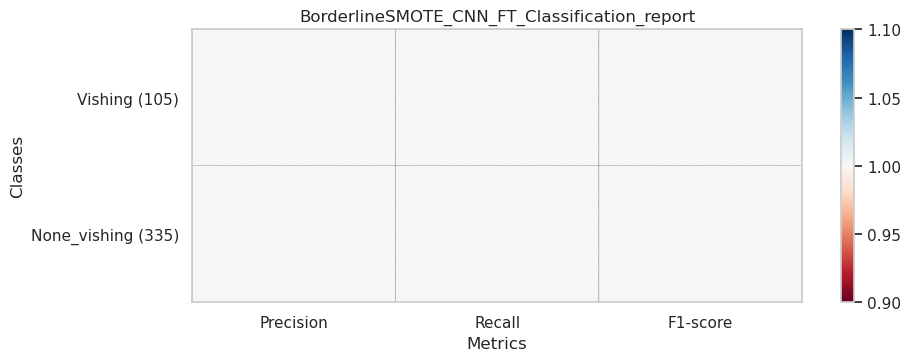

In [227]:
#plot the confusion matrix
plot_name = over_name + '_CNN_FT_Classification_report'
plot_classification_report(report_cnn_ft, plot_name)

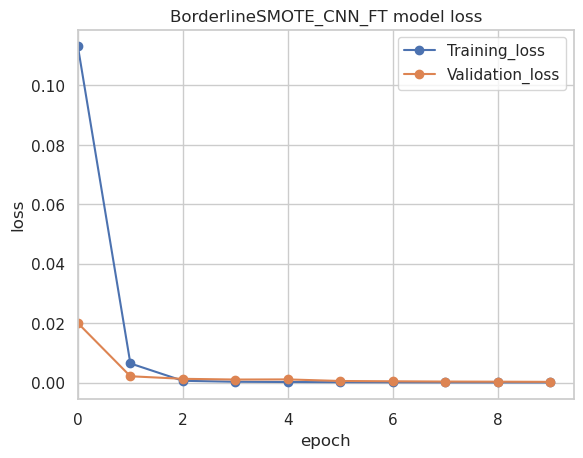

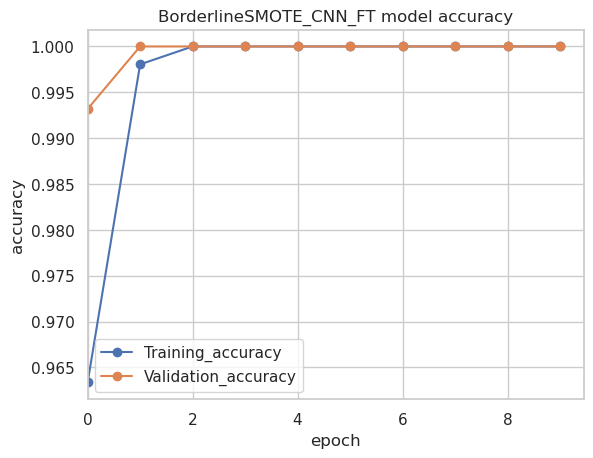

In [228]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_CNN_FT'
plot_loss_accuracy(history_cnn_ft, plot_name)

### 1D CNN layer with multiple kernel sizes

In [229]:
# Function to build, train and evaluate the 1D CNN layer with multiple kernel sizes model
def build_train_cnn_multiple_model(model_name, X_train, y_train, X_val, y_val, X_test, y_test, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, embedding_matrix=None):
    
    # define the model architecture
    model = Sequential()
    # check if the embedding_matrix is None or not
    if embedding_matrix is None:
        model.add(Embedding(max_words, embedding_dim, input_length=max_len, trainable=False))
    else:
        model.add(Embedding(max_words, embedding_dim, weights= [embedding_matrix], input_length=max_len, trainable=False))

    # model.add(SpatialDropout1D(spa_dropout_ratio))
    model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(num_filters, kernel_size+1, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    model.add(Conv1D(num_filters, kernel_size+2, activation='relu', padding='same'))
    model.add(MaxPooling1D())
    # model.add(GlobalMaxPooling1D()) #takes the maximum value over the time dimension from each feature map generated by the convolutional layers, Dimensionality Reduction, Reduces Overfitting
    model.add(Dense(dense_units, activation='relu'))
    model.add(Flatten()) # no need if used Global poooling
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # compile the model
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )

    model.compile(
        # optimizer=Adam(learning_rate=learning_rate, decay=learning_rate / decay_steps),
        optimizer=Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # print the model summary
    print(model.summary())
    print('#' * 150)

    # Create a callback that saves the best model during validation
    model_checkpoint = ModelCheckpoint(
        "models/" + model_name + "_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        # "models/BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H%M%S") + ".h5",
        monitor='val_accuracy',  # val_loss or val_accuracy 
        verbose=1,
        save_best_only=True,
        mode='max'  # max for val_accuracy, min for val_lossmode='mn'
    )
    # EarlyStopping to stop training when the validation loss has stopped improving
    early_stopping = EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=3,  # Number of epochs with no improvement after which training will be stopped.
        mode='min'
    )

    # TensorBoard for visualization
    log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # train the model
    start_time = time()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1,
        callbacks=[model_checkpoint, early_stopping, tensorboard_callback]
    )
    end_time = time()
    training_time = end_time - start_time

    # print the training time
    print('Training time: {}'.format(training_time))

    # evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Test Loss: {}'.format(loss))
    print('Test Accuracy: {}'.format(accuracy))

    # predict the test set
    # y_pred = model.predict(X_test)
    # y_pred = np.argmax(y_pred, axis=1)
    # y_test = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

    # print the precision, recall and f1-score
    model_precision = precision_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_f1_score = f1_score(y_test, y_pred)
    print('Precision: {}'.format(model_precision))
    print('Recall: {}'.format(model_recall))
    print('F1-score: {}'.format(model_f1_score))

    # print the classification report
    report = classification_report(y_test, y_pred, digits=4, target_names=['None_vishing', 'Vishing'])
    print(report)

    # print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\n-- Confusion matrix --\n', cm)
    print('True Positives(TP) = ', cm[0,0])
    print('True Negatives(TN) = ', cm[1,1])
    print('False Positives(FP) = ', cm[0,1])
    print('False Negatives(FN) = ', cm[1,0])
    
    # save the previous confusion matrix in a file following the TP, TN, FP, FN order
    # np.savetxt('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv', cm, delimiter=',', fmt='%d')
    
    # save the confusion matrix in a dataframe wih the following columns: TP, TN, FP, FN
    df_cm = pd.DataFrame(cm, columns=['None_vishing', 'Vishing'], index=['None_vishing', 'Vishing'])
    df_cm.to_csv('reports/cm_' + model_name + '_' + datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.csv')
    
    # save the model
    # model.save('models/{}.h5'.format(model_name))

    # save the history
    with open('histories/{}.pkl'.format(model_name), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    # save the results
    df_results.loc[model_name] = [model_f1_score, model_precision, model_recall, accuracy, training_time]
    # df_results.loc[model_name] = [f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy, training_time]  

    # print the results
    # df_results

    return model, history, report

In [230]:
# build, train and evaluate the CNN with mulitple kernel sizes model
model_name = over_name + '_CNN_multiple'
model_cnn_multiple, history_cnn_multiple, report_cnn_multiple = build_train_cnn_multiple_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 conv1d_18 (Conv1D)          (None, 4715, 50)          45050     
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 2357, 50)          0         
 ng1D)                                                           
                                                                 
 conv1d_19 (Conv1D)          (None, 2357, 50)          10050     
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 1178, 50)          0         
 ng1D)                                                           
                                                                 
 conv1d_20 (Conv1D)          (None, 1178, 50)        

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 5s 61ms/step - loss: 0.1748 - accuracy: 0.9194 - val_loss: 0.0477 - val_accuracy: 0.9841
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.9985
Epoch 2: val_accuracy improved from 0.98409 to 1.00000, saving model to models/BorderlineSMOTE_CNN_multiple_20240222_012318.h5
64/64 [==============================] - 2s 32ms/step - loss: 0.0091 - accuracy: 0.9985 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9985
Epoch 3: val_accuracy did not improve from 1.00000
64/64 [==============================] - 2s 27ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 3.2050e-04 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
64/64 [==============================] - 2s 28ms/step - loss: 3.2050e-04 - accuracy: 1.0000 - v

In [231]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794
BorderlineSMOTE_BiLSTM,0.980583,1.000000,0.961905,0.990909,135.702678
BorderlineSMOTE_BiLSTM_FT,1.000000,1.000000,1.000000,1.000000,222.469178
BorderlineSMOTE_stackedBiLSTM,1.000000,1.000000,1.000000,1.000000,401.532476
BorderlineSMOTE_stackedBiLSTM_FT,1.000000,1.000000,1.000000,1.000000,638.131935
BorderlineSMOTE_CNN,1.000000,1.000000,1.000000,1.000000,17.637071
BorderlineSMOTE_CNN_FT,1.000000,1.000000,1.000000,1.000000,16.766783


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


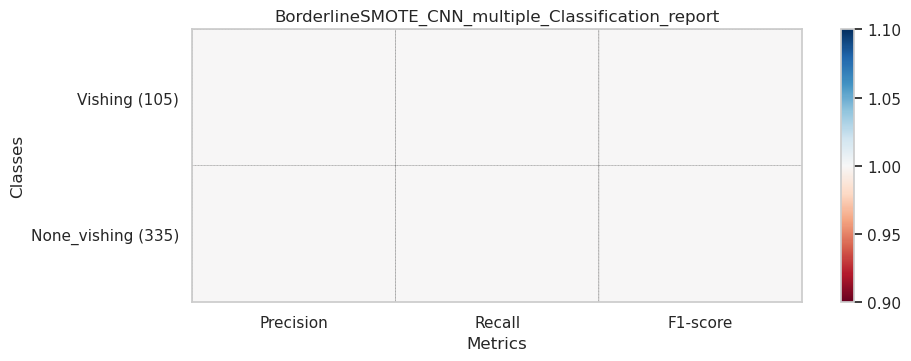

In [232]:
#plot the confusion matrix
plot_name = over_name + '_CNN_multiple_Classification_report'
plot_classification_report(report_cnn_multiple, plot_name)

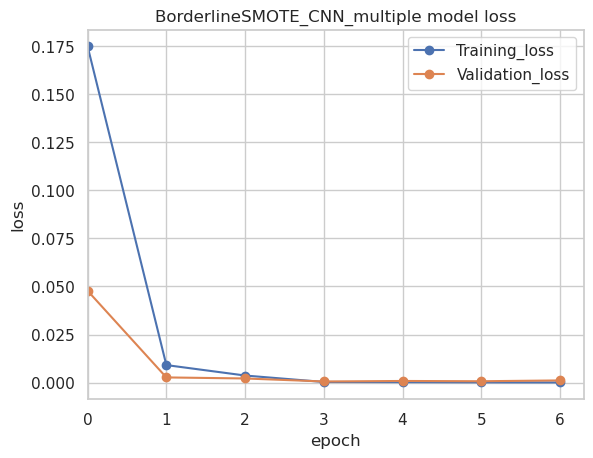

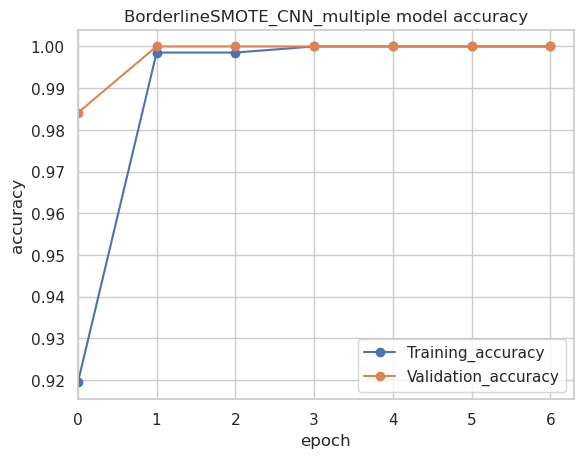

In [233]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_CNN_multiple'
plot_loss_accuracy(history_cnn_multiple, plot_name)

#### 1D CNN layer with multiple kernel sizes with FastText embedding layer

In [234]:
# build, train and evaluate the CNN with multiple kernel sizes model with FastText embedding layer
model_name = over_name + '_CNN_multiple_FT'
model_cnn_multiple_ft, history_cnn_multiple_ft, report_cnn_multiple_ft = build_train_cnn_multiple_model(model_name, X_train_res, y_train_res, X_val_pad, y_val, X_test_pad, y_test, embedding_matrix=embedding_matrix)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 4715, 300)         10153200  
                                                                 
 conv1d_21 (Conv1D)          (None, 4715, 50)          45050     
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 2357, 50)          0         
 ng1D)                                                           
                                                                 
 conv1d_22 (Conv1D)          (None, 2357, 50)          10050     
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 1178, 50)          0         
 ng1D)                                                           
                                                                 
 conv1d_23 (Conv1D)          (None, 1178, 50)        

/home/mbmk92/anaconda3/envs/vishingWSL/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 4s 44ms/step - loss: 0.1458 - accuracy: 0.9345 - val_loss: 0.0614 - val_accuracy: 0.9773
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9971
Epoch 2: val_accuracy improved from 0.97727 to 1.00000, saving model to models/BorderlineSMOTE_CNN_multiple_FT_20240222_012337.h5
64/64 [==============================] - 2s 34ms/step - loss: 0.0068 - accuracy: 0.9971 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 5.7600e-04 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
64/64 [==============================] - 2s 26ms/step - loss: 5.7600e-04 - accuracy: 1.0000 - val_loss: 1.0341e-04 - val_accuracy: 1.0000
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 1.0842e-04 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
64/64 [==============================] - 2s 26ms/step - loss: 1.0842e-04 - accur

In [235]:
# print the results
df_results

,F1_score,Precision,Recall,Accuracy,Training time
BorderlineSMOTE_LSTM,0.995261,0.990566,1.000000,0.997727,85.745191
BorderlineSMOTE_LSTM_FT,0.018868,1.000000,0.009524,0.763636,86.380069
BorderlineSMOTE_stackedLSTM,0.911917,1.000000,0.838095,0.961364,138.828577
BorderlineSMOTE_stackedLSTM_FT,0.958904,0.921053,1.000000,0.979545,131.465794
BorderlineSMOTE_BiLSTM,0.980583,1.000000,0.961905,0.990909,135.702678
BorderlineSMOTE_BiLSTM_FT,1.000000,1.000000,1.000000,1.000000,222.469178
BorderlineSMOTE_stackedBiLSTM,1.000000,1.000000,1.000000,1.000000,401.532476
BorderlineSMOTE_stackedBiLSTM_FT,1.000000,1.000000,1.000000,1.000000,638.131935
BorderlineSMOTE_CNN,1.000000,1.000000,1.000000,1.000000,17.637071
BorderlineSMOTE_CNN_FT,1.000000,1.000000,1.000000,1.000000,16.766783


[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
plotMat: [[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
support: [335, 105]


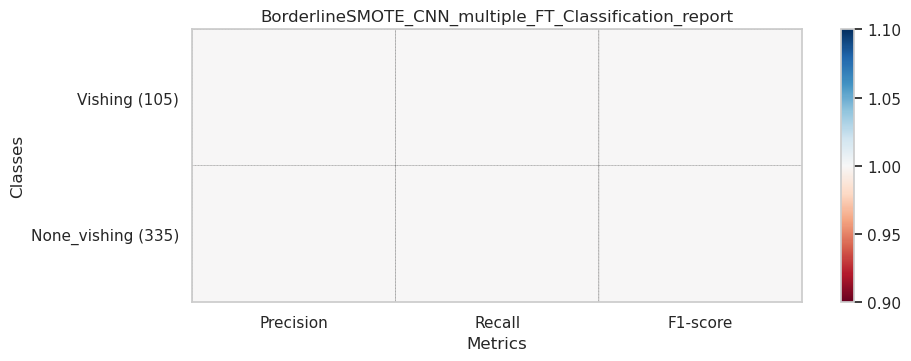

In [236]:
#plot the confusion matrix
plot_name = over_name + '_CNN_multiple_FT_Classification_report'
plot_classification_report(report_cnn_multiple_ft, plot_name)

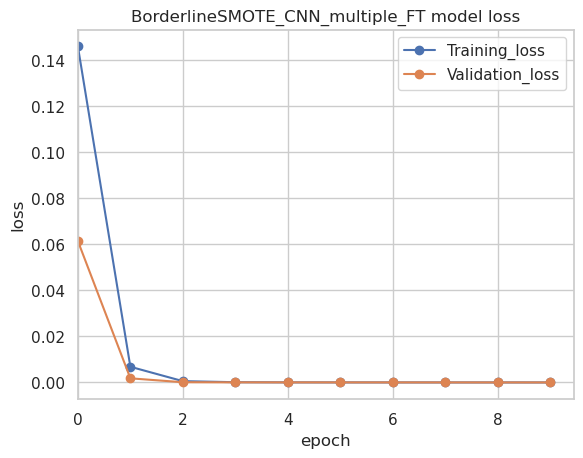

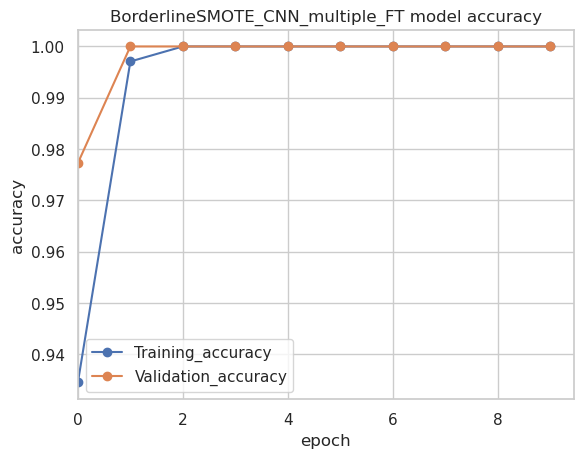

In [237]:
#plot the training and validation loss and accuracy
plot_name = over_name + '_CNN_multiple_FT'
plot_loss_accuracy(history_cnn_multiple_ft, plot_name)

## save the results in csv

In [238]:
# save the training results
df_results.to_csv("reports/" + over_name+ " _Models_performance_summary_" + datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".csv")

## Plot all the models performance


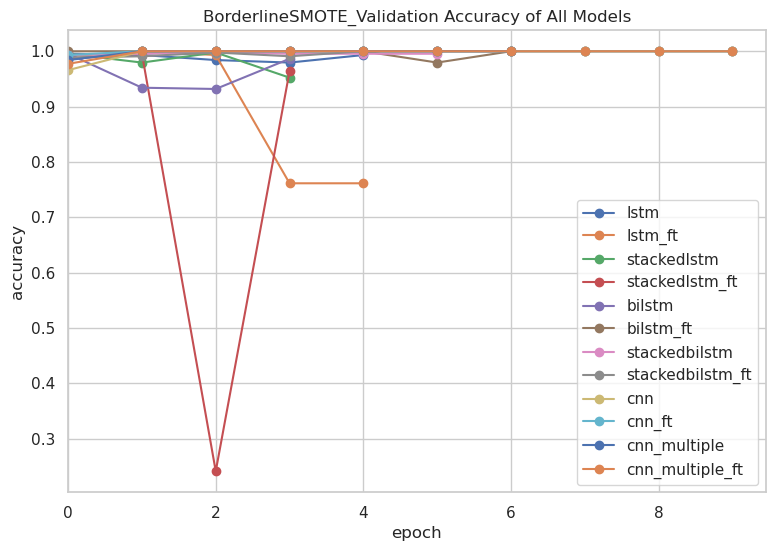

In [239]:
# plot overall accuracy on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_lstm.epoch, history_lstm.history['val_accuracy'], '-o', label='lstm')
plt.plot(history_lstm_ft.epoch, history_lstm_ft.history['val_accuracy'], '-o', label='lstm_ft')
plt.plot(history_stackedlstm.epoch, history_stackedlstm.history['val_accuracy'], '-o', label='stackedlstm')
plt.plot(history_stackedlstm_ft.epoch, history_stackedlstm_ft.history['val_accuracy'], '-o', label='stackedlstm_ft')
plt.plot(history_bilstm.epoch, history_bilstm.history['val_accuracy'], '-o', label='bilstm')
plt.plot(history_bilstm_ft.epoch, history_bilstm_ft.history['val_accuracy'], '-o', label='bilstm_ft')
plt.plot(history_stackedbilstm.epoch, history_stackedbilstm.history['val_accuracy'], '-o', label='stackedbilstm')
plt.plot(history_stackedbilstm_ft.epoch, history_stackedbilstm_ft.history['val_accuracy'], '-o', label='stackedbilstm_ft')
plt.plot(history_cnn.epoch, history_cnn.history['val_accuracy'], '-o', label='cnn')
plt.plot(history_cnn_ft.epoch,history_cnn_ft.history['val_accuracy'], '-o', label='cnn_ft')
plt.plot(history_cnn_multiple.epoch, history_cnn_multiple.history['val_accuracy'], '-o', label='cnn_multiple')
plt.plot(history_cnn_multiple_ft.epoch, history_cnn_multiple_ft.history['val_accuracy'], '-o', label='cnn_multiple_ft')
plt.title(over_name+'_Validation Accuracy of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('reports/'+over_name+'_All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('reports/'+over_name+'_All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

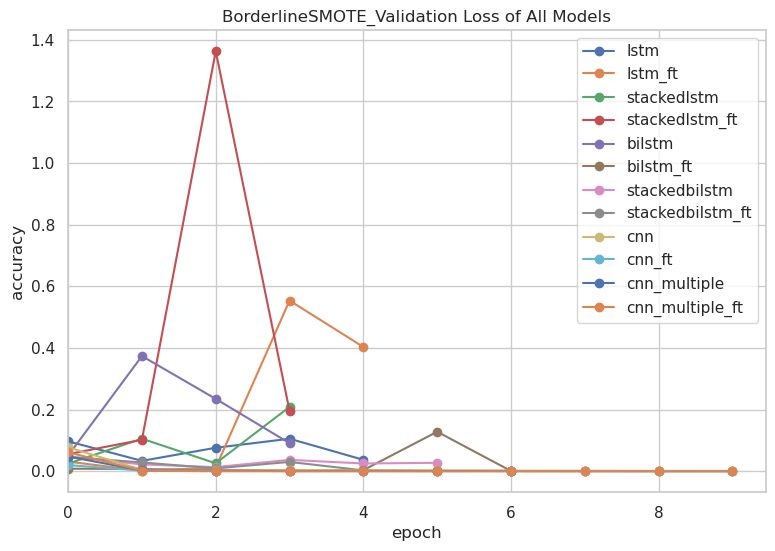

In [240]:
# plot overall looss on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_lstm.epoch, history_lstm.history['val_loss'], '-o', label='lstm')
plt.plot(history_lstm_ft.epoch, history_lstm_ft.history['val_loss'], '-o', label='lstm_ft')
plt.plot(history_stackedlstm.epoch, history_stackedlstm.history['val_loss'], '-o', label='stackedlstm')
plt.plot(history_stackedlstm_ft.epoch, history_stackedlstm_ft.history['val_loss'], '-o', label='stackedlstm_ft')
plt.plot(history_bilstm.epoch, history_bilstm.history['val_loss'], '-o', label='bilstm')
plt.plot(history_bilstm_ft.epoch, history_bilstm_ft.history['val_loss'], '-o', label='bilstm_ft')
plt.plot(history_stackedbilstm.epoch, history_stackedbilstm.history['val_loss'], '-o', label='stackedbilstm')
plt.plot(history_stackedbilstm_ft.epoch, history_stackedbilstm_ft.history['val_loss'], '-o', label='stackedbilstm_ft')
plt.plot(history_cnn.epoch, history_cnn.history['val_loss'], '-o', label='cnn')
plt.plot(history_cnn_ft.epoch, history_cnn_ft.history['val_loss'], '-o', label='cnn_ft')
plt.plot(history_cnn_multiple.epoch, history_cnn_multiple.history['val_loss'], '-o', label='cnn_multiple')
plt.plot(history_cnn_multiple_ft.epoch, history_cnn_multiple_ft.history['val_loss'], '-o', label='cnn_multiple_ft')
plt.title(over_name+'_Validation Loss of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('reports/'+over_name+'_All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
plt.savefig('reports/'+over_name+'_All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()